In [1]:
# Standard libraries
import re
import subprocess
import time
import warnings

# Data handling and numerical libraries
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical and machine learning libraries
from scipy.stats import entropy, pearsonr
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.stats import zscore


# Bioinformatics libraries from Biopython
from Bio import SeqIO, AlignIO, motifs
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqUtils.ProtParam import ProteinAnalysis, ProtParamData
from Bio.Align import MultipleSeqAlignment, AlignInfo
from Bio.motifs import create
from Bio import BiopythonDeprecationWarning

# Progress bar
from tqdm import tqdm

# Suppress specific Biopython deprecation warnings
warnings.filterwarnings('ignore', category=BiopythonDeprecationWarning)

In [2]:
# Suppress Biopython deprecation warnings
warnings.filterwarnings('ignore', category=BiopythonDeprecationWarning)

In [3]:
# Load the dataset
lysin_df = pd.read_json('lysin_unnested_data.json')

In [4]:
lysin_df.head()

,GeneID,phams,Start,Stop,Length,Name,translation,Orientation,Notes,PhageID,Accession,HostStrain,Cluster
0,20ES_CDS_10,[152741],6442,7420,978,20ES,MSLQVGSSGELVNRWIRVMKARFASYAGKLKEDGYFGLDDKAVQQE...,F,b'lysin B',20ES,KJ410132,Mycobacterium,A2
1,20ES_CDS_8,[152812],4689,5988,1299,20ES,MTAVITRKQAQWVHDMARARNGLPYAYGGAFTNDPKRSTDCSGLVL...,F,b'lysin A',20ES,KJ410132,Mycobacterium,A2
2,244_CDS_34,[152812],29920,31423,1503,244,MSVTRANVEATKRFIGERVGNPYVYGGALSPTNVHQGTDCSEVWQT...,F,b'lysin A',244,DQ398041,Mycobacterium,E
3,32HC_CDS_36,[152814],27404,28772,1368,32HC,MPGSEIPRYWPLGAGRIVTSPFGPRSGGFHAGVDFGRNGGSAGMPV...,F,b'lysin A',32HC,KJ028219,Mycobacterium,Z
4,32HC_CDS_37,[3452],28786,29938,1152,32HC,MAWKQPQLTDPPMVSEEIGKLNRRLLLAYAANSRAVEAGVQLHDVF...,F,b'lysin B',32HC,KJ028219,Mycobacterium,Z


In [5]:
# Drop columns from lysin_df
lysin_df.drop(columns=['Start', 'Stop', 'Orientation', 'Accession', 'phams'], inplace=True)

lysin_df.fillna("Unknown", inplace=True)

In [6]:
lysin_df.head()

,GeneID,Length,Name,translation,Notes,PhageID,HostStrain,Cluster
0,20ES_CDS_10,978,20ES,MSLQVGSSGELVNRWIRVMKARFASYAGKLKEDGYFGLDDKAVQQE...,b'lysin B',20ES,Mycobacterium,A2
1,20ES_CDS_8,1299,20ES,MTAVITRKQAQWVHDMARARNGLPYAYGGAFTNDPKRSTDCSGLVL...,b'lysin A',20ES,Mycobacterium,A2
2,244_CDS_34,1503,244,MSVTRANVEATKRFIGERVGNPYVYGGALSPTNVHQGTDCSEVWQT...,b'lysin A',244,Mycobacterium,E
3,32HC_CDS_36,1368,32HC,MPGSEIPRYWPLGAGRIVTSPFGPRSGGFHAGVDFGRNGGSAGMPV...,b'lysin A',32HC,Mycobacterium,Z
4,32HC_CDS_37,1152,32HC,MAWKQPQLTDPPMVSEEIGKLNRRLLLAYAANSRAVEAGVQLHDVF...,b'lysin B',32HC,Mycobacterium,Z


In [7]:
# Define the search patterns for each lysin type
lysin_A_patterns = [
    'lysin A', 'putative lysin A', 'lysin A, protease M23 domain',
    'lysin A, N-acetylmuramoyl-L-alanine amidase domain', 'lysin A, L-Ala-D-Glu peptidase domain',
    'lysin A, glycosyl hydrolase domain', 'lysin A, protease C39 domain',
    'lysin A, N-acetylmuramoyl-L-alanine amidase', 'lysin A, M23 peptidase domain',
    'lysin A, amidase domain', 'lysin A, L-ala D-glu peptidase domain',
    'lysin A glycosidase domain', 'lysin A amidase domain', 'lysin A peptidase domain',
    'lysin A, N-acetylmuramoyl-L-alanine amides domain', 'lysin A, protease M15 domain',
    'lysin A N-acetylmuramoyl-L-alanine amidase domain', 'lysin A L-Ala-D-Glu peptidase domain',
    'lysin A, protease domain', 'lysin A, N-acetyl-B-D-muramidase domain',
    'lysin A glycosyl hydrolase domain', 'lysin A, GH19 glycoside hydrolase domain',
    'lysin A, N-acetyl-beta-D-muramidase domain', 'lysin A, peptidase domain',
    'lysinA, hydrolase domain', 'Lysin A', 'lysin A, N-acetylmuramoyl-Lalanine amidase domain',
    'lysin A, l-ala-d-glu peptidase domain', 'lysin A, C39 peptidase domain',
    'lysin A, glycosyl hyrdrolase domain', 'lysin A, L-Ala,-D-Glu peptidase domain',
    'lysin A, M15 protease', 'lysin A, protease C39', 'putitive lysin A'
]

lysin_B_patterns = [
    'lysin B', 'putative lysin B', 'lysinB protein', 'putitive lysin B'
]

endolysin_patterns = [
    'endolysin', 'LysM-like endolysin', 'endolysin, L-Ala-D-Glu peptidase domain',
    'endolysin, N-acetylmuramoyl-L-alanine amidase domain', 'endolysin, protease M23 domain',
    'endolysin, protease C39 domain', 'endolysin, glycosyl hydrolase domain',
    'endolysin domain protein', 'endolysin, protease M15 domain', 'endolysin amidase',
    'endolysin endopeptidase/amidase', 'putative endolysin', 'endolysin, protease M23 domain and cell wall binding domain',
    'endolysin, protease domain'
]

# Combine all patterns into regex patterns
lysin_A_pattern = '|'.join(lysin_A_patterns)
lysin_B_pattern = '|'.join(lysin_B_patterns)
endolysin_pattern = '|'.join(endolysin_patterns)

# Define a function to determine the LysinType
def determine_lysin_type(notes):
    if re.search(lysin_A_pattern, notes, re.IGNORECASE):
        return 'lysin A'
    elif re.search(lysin_B_pattern, notes, re.IGNORECASE):
        return 'lysin B'
    elif re.search(endolysin_pattern, notes, re.IGNORECASE):
        return 'endolysin'
    else:
        return 'unknown'

# Apply the function to create a new column LysinType
lysin_df['LysinType'] = lysin_df['Notes'].apply(determine_lysin_type)

In [8]:
lysin_df.head()

,GeneID,Length,Name,translation,Notes,PhageID,HostStrain,Cluster,LysinType
0,20ES_CDS_10,978,20ES,MSLQVGSSGELVNRWIRVMKARFASYAGKLKEDGYFGLDDKAVQQE...,b'lysin B',20ES,Mycobacterium,A2,lysin B
1,20ES_CDS_8,1299,20ES,MTAVITRKQAQWVHDMARARNGLPYAYGGAFTNDPKRSTDCSGLVL...,b'lysin A',20ES,Mycobacterium,A2,lysin A
2,244_CDS_34,1503,244,MSVTRANVEATKRFIGERVGNPYVYGGALSPTNVHQGTDCSEVWQT...,b'lysin A',244,Mycobacterium,E,lysin A
3,32HC_CDS_36,1368,32HC,MPGSEIPRYWPLGAGRIVTSPFGPRSGGFHAGVDFGRNGGSAGMPV...,b'lysin A',32HC,Mycobacterium,Z,lysin A
4,32HC_CDS_37,1152,32HC,MAWKQPQLTDPPMVSEEIGKLNRRLLLAYAANSRAVEAGVQLHDVF...,b'lysin B',32HC,Mycobacterium,Z,lysin B


In [9]:
# Drop rows with LysinType 'Unknown'
lysin_df = lysin_df[lysin_df['LysinType'] != 'unknown']

In [10]:
# Check for missing values in each column
missing_values = lysin_df.isnull().sum()
missing_values

GeneID         0
Length         0
Name           0
translation    0
Notes          0
PhageID        0
HostStrain     0
Cluster        0
LysinType      0
dtype: int64

In [11]:
# Get counts of each LysinType
lysin_type_counts = lysin_df['LysinType'].value_counts()
lysin_type_counts

LysinType
lysin A      3458
lysin B      2528
endolysin    1147
Name: count, dtype: int64

In [12]:
# Filter the dataframe by Lysin type B
lysin_b_df = lysin_df[lysin_df['LysinType'] == 'lysin B']

In [13]:
# Function to calculate properties
def calculate_properties(seq):
    analyzed_seq = ProteinAnalysis(seq)
    molecular_weight = analyzed_seq.molecular_weight()
    aromaticity = analyzed_seq.aromaticity()
    instability_index = analyzed_seq.instability_index()
    gravy = analyzed_seq.gravy()
    isoelectric_point = analyzed_seq.isoelectric_point()
    aliphatic_index = (analyzed_seq.count_amino_acids().get('A', 0) + 
                       2.9 * analyzed_seq.count_amino_acids().get('V', 0) + 
                       3.9 * (analyzed_seq.count_amino_acids().get('I', 0) + analyzed_seq.count_amino_acids().get('L', 0))) / len(seq) * 100
    kd_scale = ProtParamData.kd
    hydrophobicity_values = [kd_scale[aa] for aa in seq if aa in kd_scale]
    hydrophobicity = np.mean(hydrophobicity_values) if hydrophobicity_values else 0
    return {
        'Molecular_Weight': molecular_weight,
        'Aromaticity': aromaticity,
        'Instability_Index': instability_index,
        'Gravy': gravy,
        'Isoelectric_Point': isoelectric_point,
        'Aliphatic_Index': aliphatic_index,
        'Hydrophobicity': hydrophobicity,
        'Protein_Length': len(seq)
    }

In [14]:
# Ensure combined_lysin_b_df only includes lysin B sequences
combined_lysin_b_df = lysin_df[lysin_df['LysinType'] == 'lysin B']

# Ensure GeneID is unique
combined_lysin_b_df = combined_lysin_b_df.drop_duplicates(subset='GeneID')

# Apply the function to each row in the dataframe
properties_df = combined_lysin_b_df['translation'].apply(calculate_properties).apply(pd.Series)

# Merge the calculated properties back to the original dataframe
combined_lysin_b_df = pd.concat([combined_lysin_b_df, properties_df], axis=1)

In [15]:
combined_lysin_b_df.head()

,GeneID,Length,Name,translation,Notes,PhageID,HostStrain,Cluster,LysinType,Molecular_Weight,Aromaticity,Instability_Index,Gravy,Isoelectric_Point,Aliphatic_Index,Hydrophobicity,Protein_Length
0,20ES_CDS_10,978,20ES,MSLQVGSSGELVNRWIRVMKARFASYAGKLKEDGYFGLDDKAVQQE...,b'lysin B',20ES,Mycobacterium,A2,lysin B,36578.3514,0.107692,28.285877,-0.326462,5.823575,82.584615,-0.326462,325.0
4,32HC_CDS_37,1152,32HC,MAWKQPQLTDPPMVSEEIGKLNRRLLLAYAANSRAVEAGVQLHDVF...,b'lysin B',32HC,Mycobacterium,Z,lysin B,41216.7621,0.091384,41.574413,0.020366,6.173590,89.947781,0.020366,383.0
6,39HC_CDS_42,996,39HC,MSLALGSSGLMAAAWAAMMRLRFPGYALGRDGKPLGVDGYFGYDEE...,b'lysin B',39HC,Mycobacterium,B6,lysin B,35566.7986,0.084592,26.417221,-0.292447,6.453408,74.048338,-0.292447,331.0
8,40AC_CDS_14,978,40AC,MSLTLGSQGEIVNRWIRVMKARFVSYAGKLREDAYFGLDDAEVQKE...,b'lysin B',40AC,Mycobacterium,A17,lysin B,36595.5658,0.104615,33.097846,-0.276308,6.379347,86.769231,-0.276308,325.0
10,40BC_CDS_42,996,40BC,MSLALGSSGLMAAAWAAMMRLRFPGYALGRDGKPLGVDGYFGYDEE...,b'lysin B',40BC,Mycobacterium,B6,lysin B,35566.7986,0.084592,26.417221,-0.292447,6.453408,74.048338,-0.292447,331.0


In [16]:
# Visualize the properties to identify potential outliers
key_features = [
     'Length', 'Molecular_Weight', 'Aromaticity', 'Instability_Index',
    'Gravy', 'Isoelectric_Point', 'Aliphatic_Index',
    'Hydrophobicity', 'Protein_Length'
]

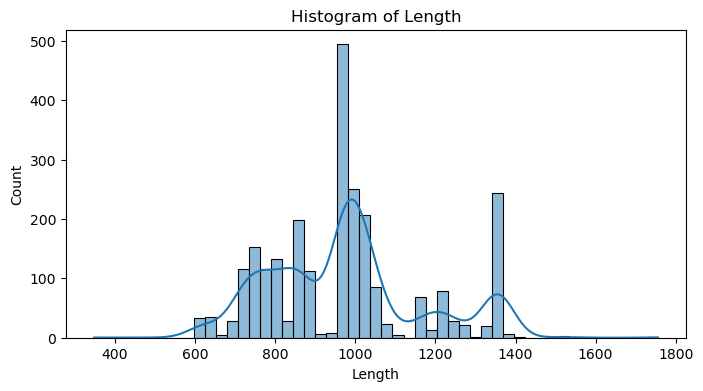

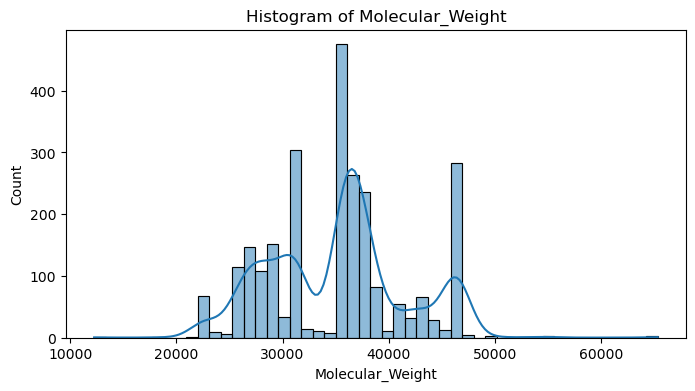

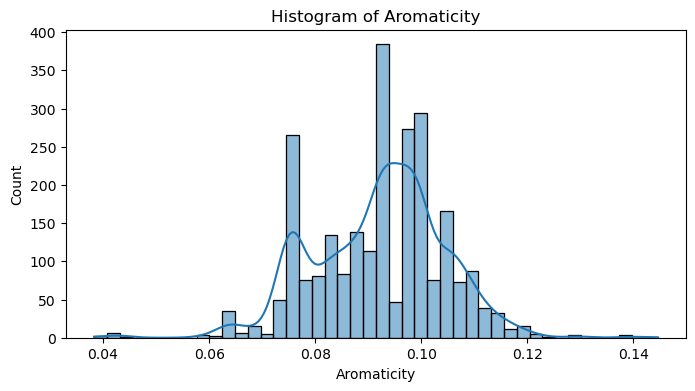

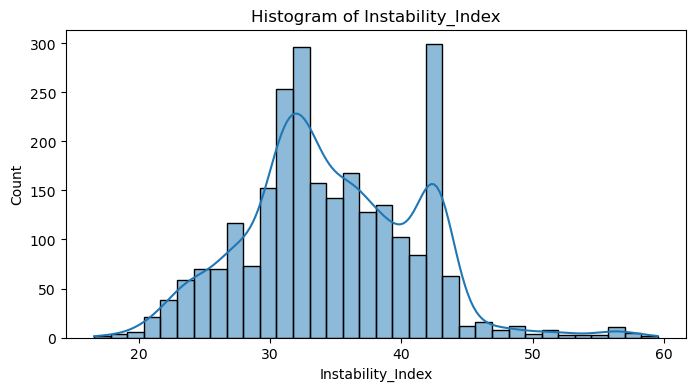

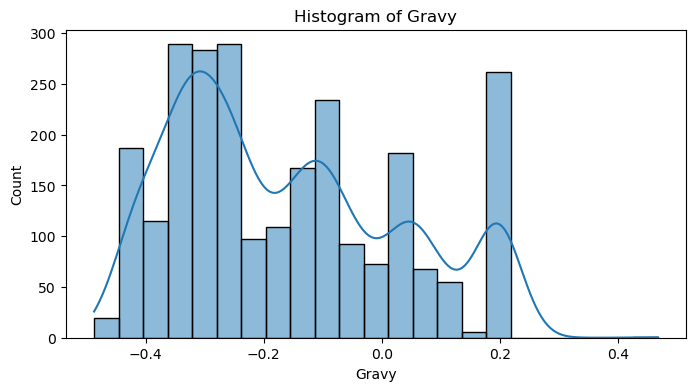

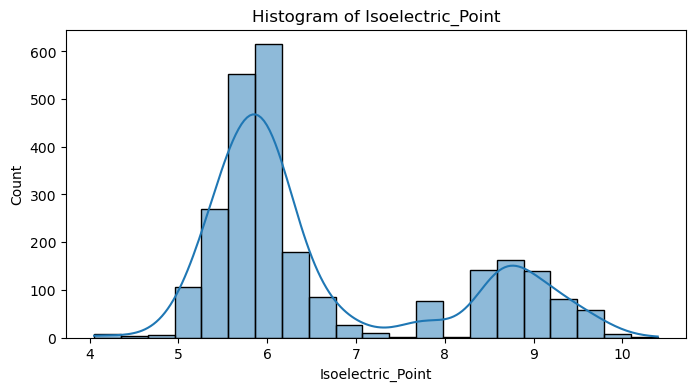

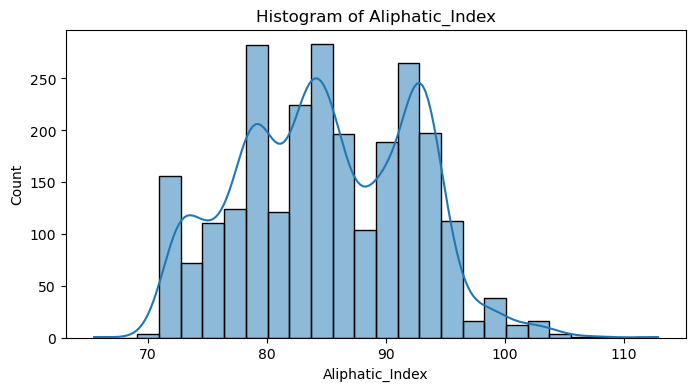

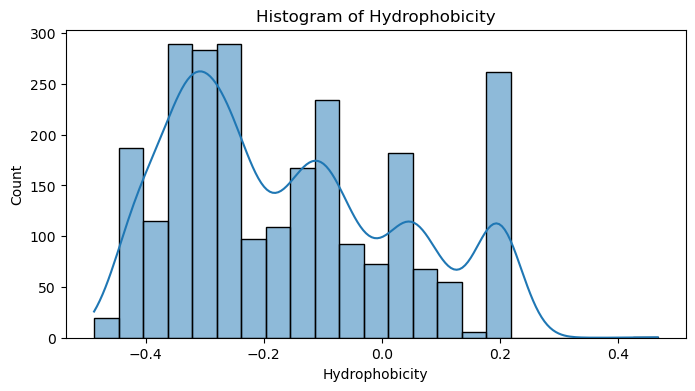

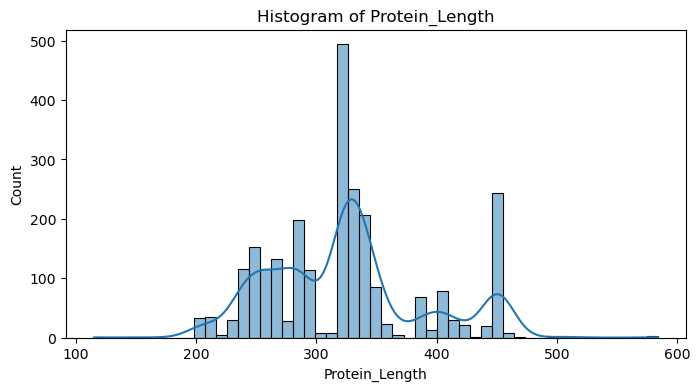

In [17]:
# Create histograms for each feature
for feature in key_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(combined_lysin_b_df[feature], kde=True)
    plt.title(f'Histogram of {feature}')
    plt.show()

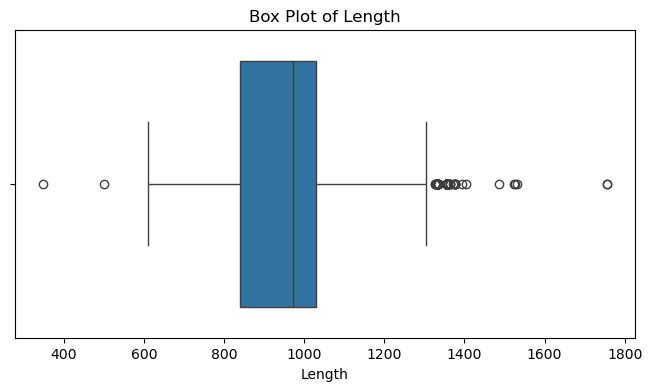

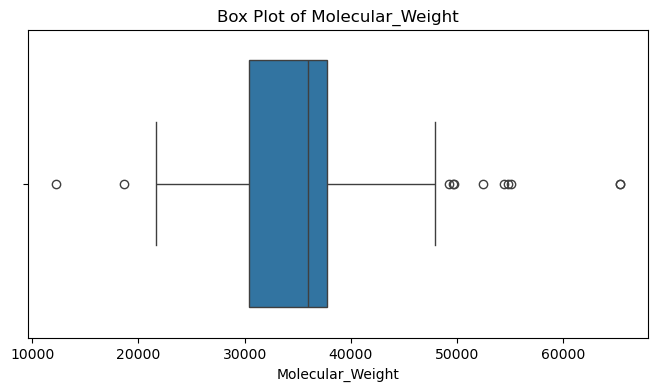

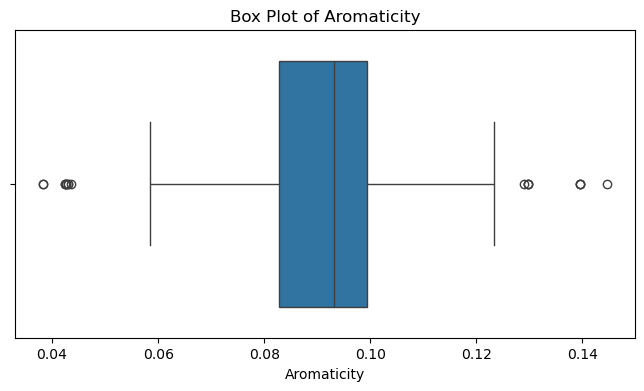

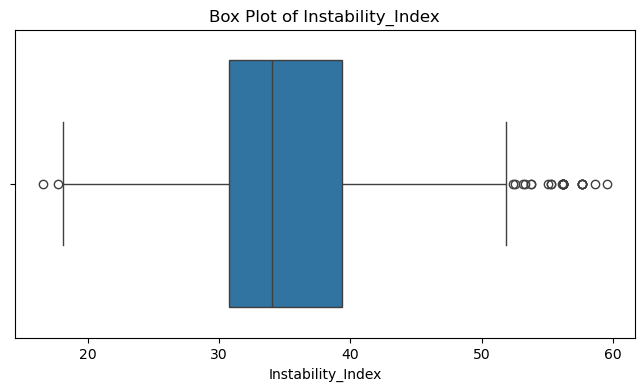

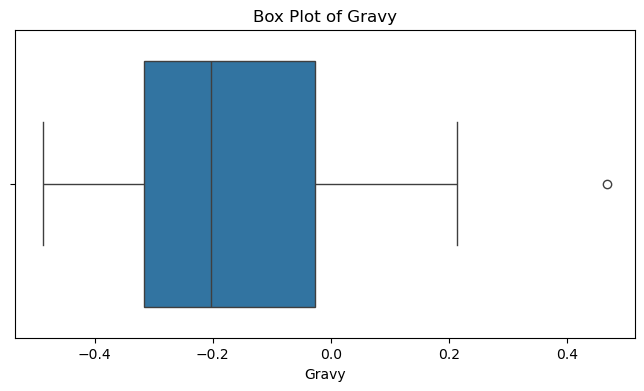

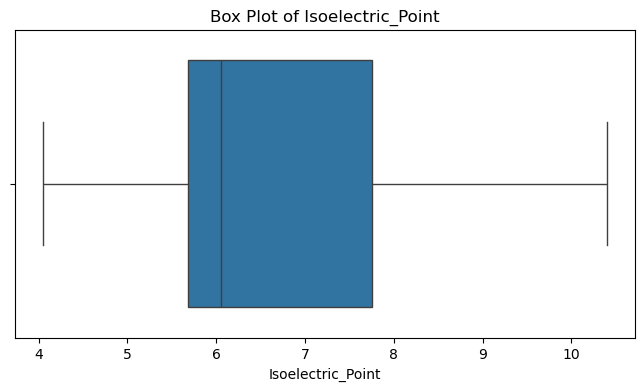

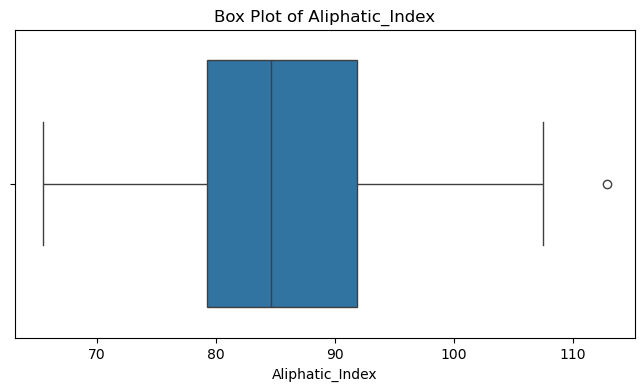

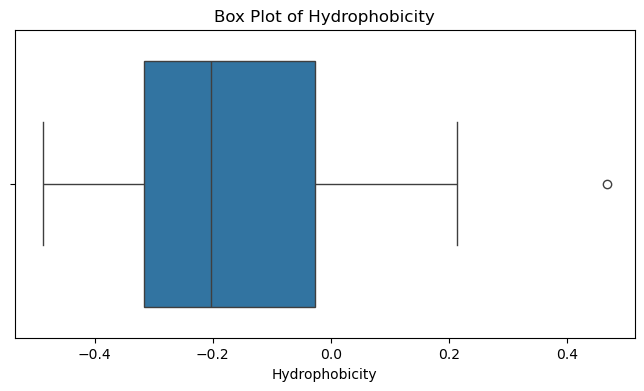

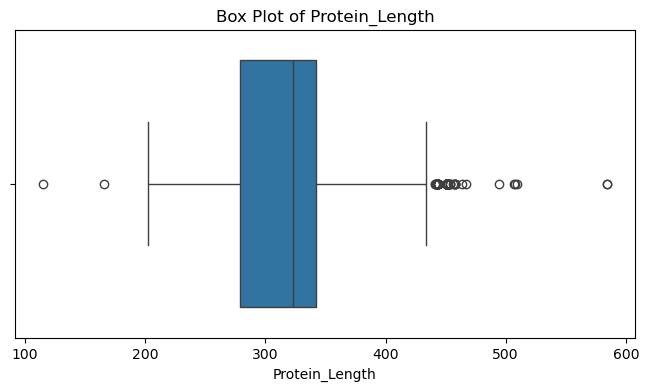

In [18]:
# Create box plots for each feature
for feature in key_features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=combined_lysin_b_df[feature])
    plt.title(f'Box Plot of {feature}')
    plt.show()

In [19]:
# Identify outliers using Z-scores
z_scores = combined_lysin_b_df[key_features].apply(zscore)

# Determine the number of outliers for each key feature
outliers_by_feature = (z_scores.abs() > 3).sum()

# Print the number of outliers for each feature
print("Number of outliers for each feature:")
print(outliers_by_feature)

# Determine the total number of outliers
outliers = (z_scores.abs() > 3).any(axis=1)

# Print the number of outliers and their GeneIDs
num_outliers = outliers.sum()
outlier_gene_ids = combined_lysin_b_df[outliers]['GeneID']

print(f"Total number of outliers: {num_outliers}")
print("GeneIDs of outliers:")
print(outlier_gene_ids.tolist())

Number of outliers for each feature:
Length                3
Molecular_Weight      6
Aromaticity          17
Instability_Index    21
Gravy                 1
Isoelectric_Point     0
Aliphatic_Index       3
Hydrophobicity        1
Protein_Length        3
dtype: int64
Total number of outliers: 45
GeneIDs of outliers:
['Aikoy_CDS_46', 'Astro_CDS_8', 'Attis_CDS_24', 'Bjanes7_CDS_24', 'Clap_CDS_24', 'Cuke_CDS_31', 'Cynthia_CDS_24', 'DinoDaryn_CDS_25', 'Ebert_CDS_24', 'EdmundFerry_CDS_55', 'Finch_CDS_202', 'FireCastle_CDS_28', 'Fowlmouth_CDS_34', 'GemG_CDS_24', 'Gizermo_CDS_24', 'Goodman_CDS_30', 'Haley23_CDS_24', 'Jera_CDS_30', 'Johann_CDS_30', 'Leopard_CDS_46', 'LordFarquaad_CDS_24', 'Lucky10_CDS_24', 'Mocha12_CDS_24', 'Morkie_CDS_24', 'MrMiyagi_CDS_34', 'NiceHouse_CDS_118', 'Onyinye_CDS_47', 'PermaG_CDS_30', 'PhorbesPhlower_CDS_24', 'Sahara_CDS_23', 'Saintus_CDS_8', 'Savage_CDS_24', 'SBlackberry_CDS_29', 'SoilAssassin_CDS_24', 'Sproutie_CDS_24', 'Tiamoceli_CDS_57', 'Trina_CDS_139', 'Tuerto

In [20]:
# Filter out outliers
filtered_lysin_b_df = combined_lysin_b_df[~outliers]

In [21]:
# Perform MSA on the filtered data
def perform_msa(dataframe, output_prefix):
    sequences = [SeqRecord(Seq(row['translation']), id=row['GeneID']) for index, row in tqdm(dataframe.iterrows(), total=dataframe.shape[0], desc='Creating SeqRecord objects')]
    fasta_file = f"{output_prefix}_lysins.fasta"
    SeqIO.write(sequences, fasta_file, "fasta")
    print(f"Sequences written to {fasta_file}")
    aligned_file = f"aligned_{output_prefix}_lysins.fasta"
    clustal_omega_command = ["clustalo", "-i", fasta_file, "-o", aligned_file, "--force"]
    print(f"Running Clustal Omega for multiple sequence alignment on {output_prefix}...")
    subprocess.run(clustal_omega_command)
    print(f"Multiple sequence alignment completed and saved to {aligned_file}")
    alignment = AlignIO.read(aligned_file, "fasta")
    print(f"Alignment read from {aligned_file}")
    return alignment

# Perform MSA for Lysin B dataframe
alignment_lysin_b = perform_msa(filtered_lysin_b_df, "lysin_b")

Creating SeqRecord objects: 100%|████████████████████████| 2483/2483 [00:00<00:00, 6609.11it/s]


Sequences written to lysin_b_lysins.fasta
Running Clustal Omega for multiple sequence alignment on lysin_b...
Multiple sequence alignment completed and saved to aligned_lysin_b_lysins.fasta
Alignment read from aligned_lysin_b_lysins.fasta


In [22]:
# Print the consensus sequence
def print_consensus(consensus, alignment_name):
    print(f"Consensus Sequence for {alignment_name}:")
    consensus_str = str(consensus)
    for i in range(0, len(consensus_str), 80):
        print(consensus_str[i:i+80])
    print("\n")

summary_align = AlignInfo.SummaryInfo(alignment_lysin_b)
consensus = summary_align.dumb_consensus()
print_consensus(consensus, "Lysin B")

Consensus Sequence for Lysin B:
MSTPLWLRPSSVRALKAWSAVTRTAIRRTTASRISDGIPGRPTVXXXXGXXXXXPXXRPTANTGTSXXXRMXXXXGXXXX
XXGXLVXXWXXAEGMRVXXXXGXYXXLXXXXXMMTXXXXXXXXXXXGXXAANXXXXIXXXXXYGKNXXXXXXXXXXXXXX
XXXXXXXXXXXXXXXXXXYXXXXXXXXXXXQXRXXXXXXXGXXXXXXXXLPXXXGXXXXXXXXXXXXLXXXXXPAXXPXX
XXXXXXXXXXXXGTGXXXXXXXXXXLGAVXXXXPSXGXXXXNXXGXXXXXXXXXXXXRDTDXXFDWATKKQMQLLXXQSX
VXXXGTGWXXXXXXXXXXXXXXXXXXXXPXXAXXXGXPXXXXXXXXXLXXXXXPXXXXSXXXLTEFMNNDPREHERTAYX
XXXLPFXXXTGXXXVRXXXXXLXXXXXXXXXXXXXPGFXXXXXXXXXXXXXXXXXXQGVFHNTNAFLNPDPFHNFVQATN
EGAAEAXXXXXXXXGXXXXXXGYSXGAXXXXXXXXXXXXXXGFTIPKTGXLXXXGXXHLXXXXXXXXXXXXXGXPXRXXX
GXXXXXXXYSDXGXXXXXXXXXXXXXXGIXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXPXXANSRFGXXDXYXXXXXX
PXXXXXXXXXXXXGXXDXXXXXXXXXXXXXXXXXVXXXXXXXXXXXXXXXXGPXXXXAQGXXXXXXXXXXXXXXXXXXXX
XXXXXXXXXXXXWWXXXXXXXXXXXXXXXXXXAGIXXXLXXGGVGXXXGGLLXXXGYXGLATGGGGXLGGXLGXGXLGXX
LGGGGMFXXXXXXXXXXXXXXXXXXLXXIXXXXXXXXXPLLLPXXXXXLXGXIXGXVGGXXTGXPXXXXXAXXXAXXXXX
XFXXXXXXXXXXHXXXYXXXXXXXXLXXXXTXXXXAXXXXRXXAXAXXXXXXXXXXXAXXXPXXXSXWXXXXPFDTA

In [23]:
# Calculate distances from the consensus sequence
def hamming_distance(seq1, seq2):
    return sum(a != b for a, b in zip(seq1, seq2) if a != '-' and b != '-')

distances_from_consensus = [
    sum(a != b for a, b in zip(str(record.seq), str(consensus))) / alignment_lysin_b.get_alignment_length()
    for record in tqdm(alignment_lysin_b, desc="Calculating Distances from Consensus")
]

hamming_distances = [
    hamming_distance(str(record.seq), str(consensus))
    for record in tqdm(alignment_lysin_b, desc="Calculating Hamming Distances")
]

df_lysin_b = pd.DataFrame({
    "GeneID": [record.id for record in alignment_lysin_b],
    "Distance_From_Consensus": distances_from_consensus,
    "Hamming_Distance": hamming_distances
})

Calculating Hamming Distances: 100%|█████████████████████| 2483/2483 [00:00<00:00, 8752.11it/s]


In [24]:
# Merge with the original lysin_b_df to include the new metrics
combined_lysin_b_df = filtered_lysin_b_df.merge(df_lysin_b, on='GeneID', how='inner')

In [25]:
combined_lysin_b_df.head()

,GeneID,Length,Name,translation,Notes,PhageID,HostStrain,Cluster,LysinType,Molecular_Weight,Aromaticity,Instability_Index,Gravy,Isoelectric_Point,Aliphatic_Index,Hydrophobicity,Protein_Length,Distance_From_Consensus,Hamming_Distance
0,20ES_CDS_10,978,20ES,MSLQVGSSGELVNRWIRVMKARFASYAGKLKEDGYFGLDDKAVQQE...,b'lysin B',20ES,Mycobacterium,A2,lysin B,36578.3514,0.107692,28.285877,-0.326462,5.823575,82.584615,-0.326462,325.0,0.965803,292
1,32HC_CDS_37,1152,32HC,MAWKQPQLTDPPMVSEEIGKLNRRLLLAYAANSRAVEAGVQLHDVF...,b'lysin B',32HC,Mycobacterium,Z,lysin B,41216.7621,0.091384,41.574413,0.020366,6.173590,89.947781,0.020366,383.0,0.958549,343
2,39HC_CDS_42,996,39HC,MSLALGSSGLMAAAWAAMMRLRFPGYALGRDGKPLGVDGYFGYDEE...,b'lysin B',39HC,Mycobacterium,B6,lysin B,35566.7986,0.084592,26.417221,-0.292447,6.453408,74.048338,-0.292447,331.0,0.969948,302
3,40AC_CDS_14,978,40AC,MSLTLGSQGEIVNRWIRVMKARFVSYAGKLREDAYFGLDDAEVQKE...,b'lysin B',40AC,Mycobacterium,A17,lysin B,36595.5658,0.104615,33.097846,-0.276308,6.379347,86.769231,-0.276308,325.0,0.965803,292
4,40BC_CDS_42,996,40BC,MSLALGSSGLMAAAWAAMMRLRFPGYALGRDGKPLGVDGYFGYDEE...,b'lysin B',40BC,Mycobacterium,B6,lysin B,35566.7986,0.084592,26.417221,-0.292447,6.453408,74.048338,-0.292447,331.0,0.969948,302


In [26]:
# Initialize label encoder
label_encoder = LabelEncoder()

# Encode 'Cluster' and 'HostStrain'
combined_lysin_b_df['Cluster_encoded'] = label_encoder.fit_transform(combined_lysin_b_df['Cluster'])
combined_lysin_b_df['HostStrain_encoded'] = label_encoder.fit_transform(combined_lysin_b_df['HostStrain'])

In [27]:
combined_lysin_b_df.head()

,GeneID,Length,Name,translation,Notes,PhageID,HostStrain,Cluster,LysinType,Molecular_Weight,...,Instability_Index,Gravy,Isoelectric_Point,Aliphatic_Index,Hydrophobicity,Protein_Length,Distance_From_Consensus,Hamming_Distance,Cluster_encoded,HostStrain_encoded
0,20ES_CDS_10,978,20ES,MSLQVGSSGELVNRWIRVMKARFASYAGKLKEDGYFGLDDKAVQQE...,b'lysin B',20ES,Mycobacterium,A2,lysin B,36578.3514,...,28.285877,-0.326462,5.823575,82.584615,-0.326462,325.0,0.965803,292,7,1
1,32HC_CDS_37,1152,32HC,MAWKQPQLTDPPMVSEEIGKLNRRLLLAYAANSRAVEAGVQLHDVF...,b'lysin B',32HC,Mycobacterium,Z,lysin B,41216.7621,...,41.574413,0.020366,6.173590,89.947781,0.020366,383.0,0.958549,343,142,1
2,39HC_CDS_42,996,39HC,MSLALGSSGLMAAAWAAMMRLRFPGYALGRDGKPLGVDGYFGYDEE...,b'lysin B',39HC,Mycobacterium,B6,lysin B,35566.7986,...,26.417221,-0.292447,6.453408,74.048338,-0.292447,331.0,0.969948,302,27,1
3,40AC_CDS_14,978,40AC,MSLTLGSQGEIVNRWIRVMKARFVSYAGKLREDAYFGLDDAEVQKE...,b'lysin B',40AC,Mycobacterium,A17,lysin B,36595.5658,...,33.097846,-0.276308,6.379347,86.769231,-0.276308,325.0,0.965803,292,5,1
4,40BC_CDS_42,996,40BC,MSLALGSSGLMAAAWAAMMRLRFPGYALGRDGKPLGVDGYFGYDEE...,b'lysin B',40BC,Mycobacterium,B6,lysin B,35566.7986,...,26.417221,-0.292447,6.453408,74.048338,-0.292447,331.0,0.969948,302,27,1


In [28]:
# Define the key features you want to plot
key_features = [
    'Length','Molecular_Weight',
    'Aromaticity', 'Instability_Index', 'Gravy', 'Isoelectric_Point', 
    'Aliphatic_Index', 'Hydrophobicity', 'Protein_Length', 'Distance_From_Consensus', 'Hamming_Distance'
]

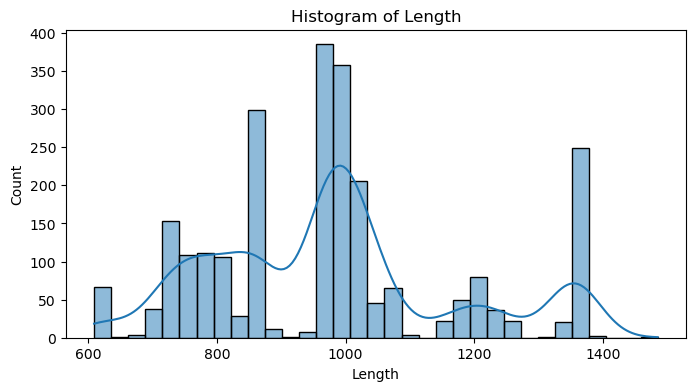

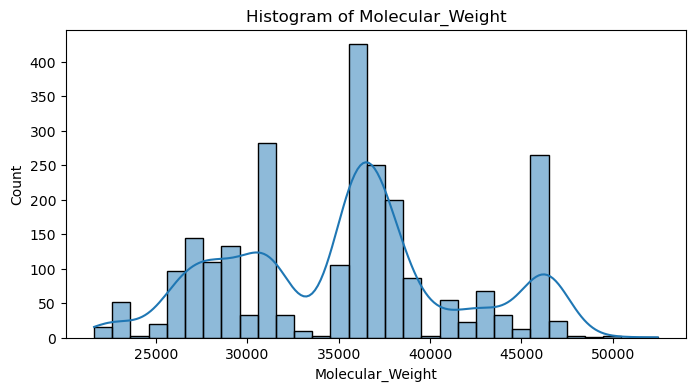

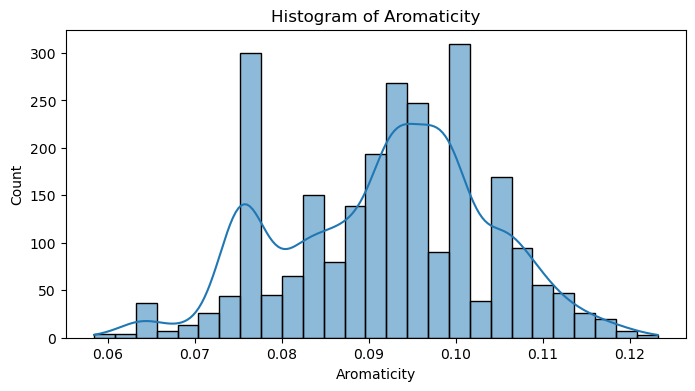

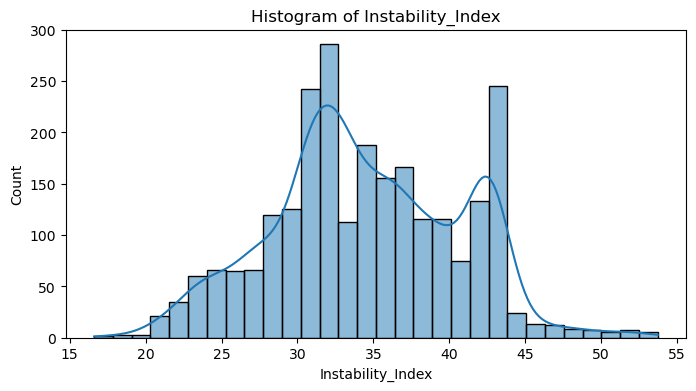

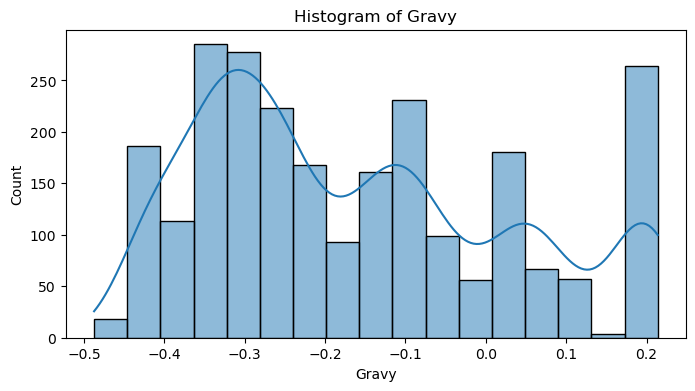

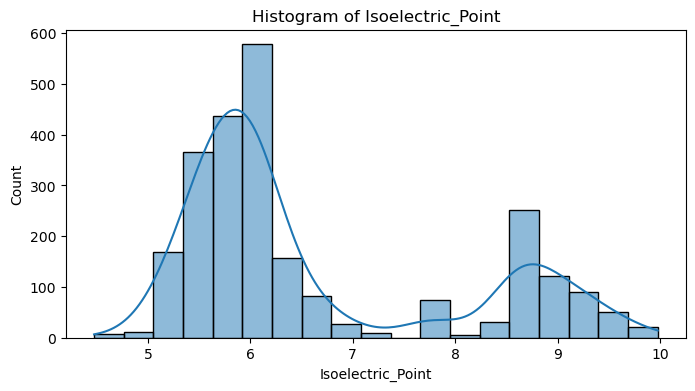

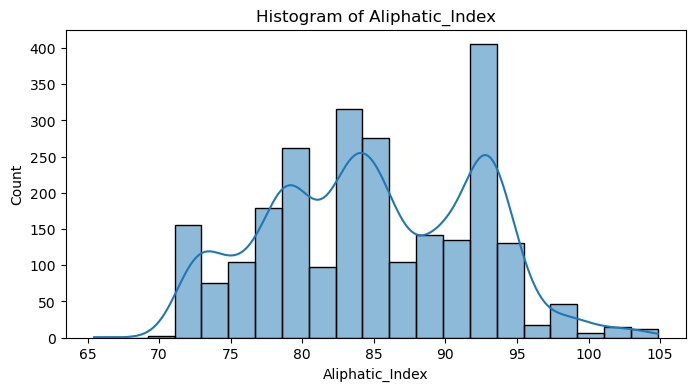

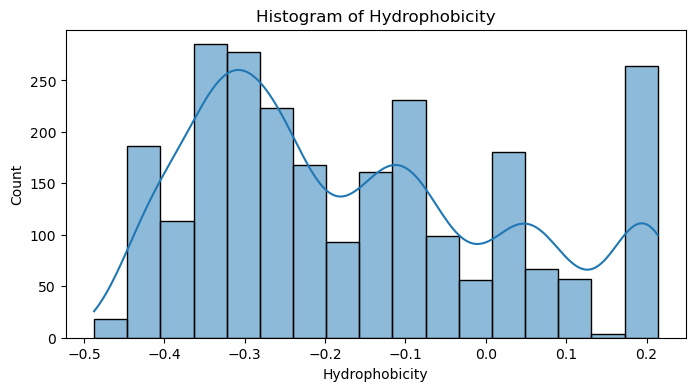

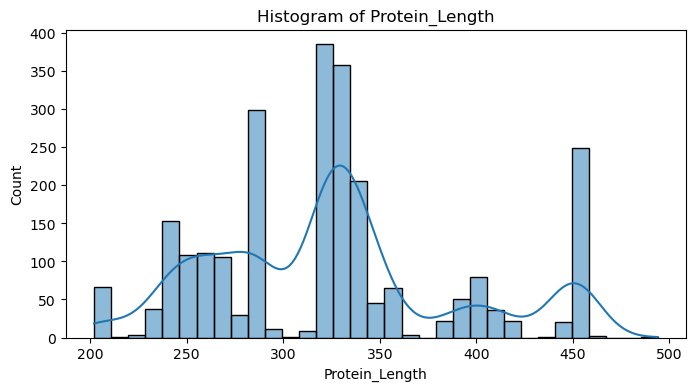

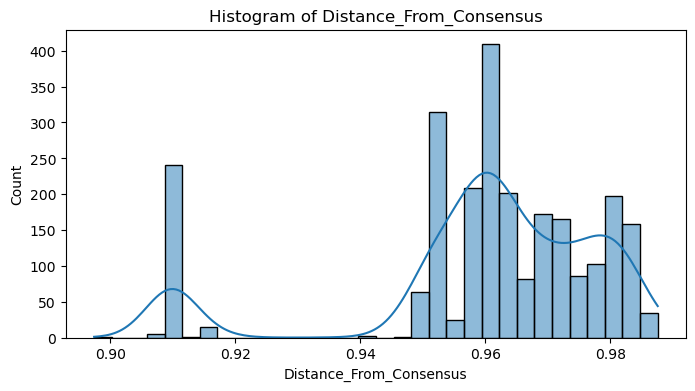

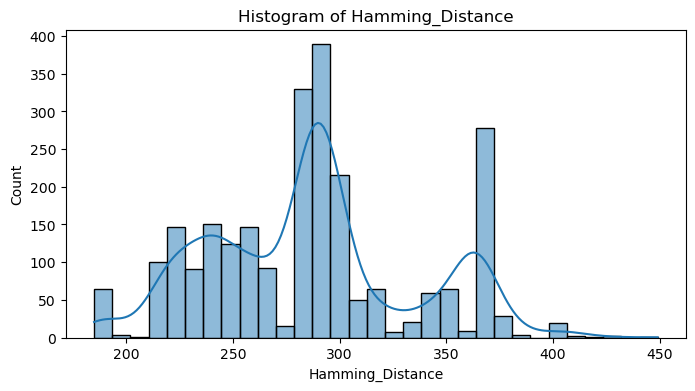

In [29]:
# Create histograms for each feature
for feature in key_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(combined_lysin_b_df[feature], kde=True)
    plt.title(f'Histogram of {feature}')
    plt.show()

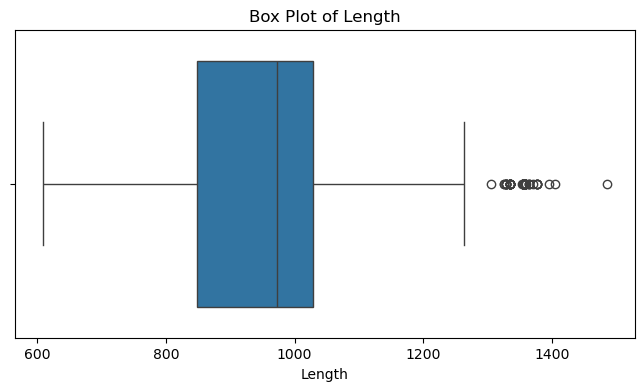

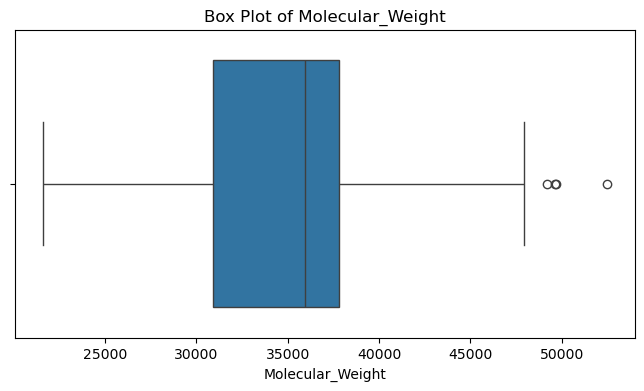

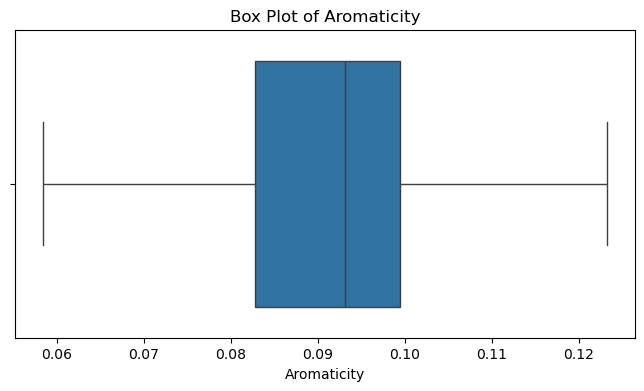

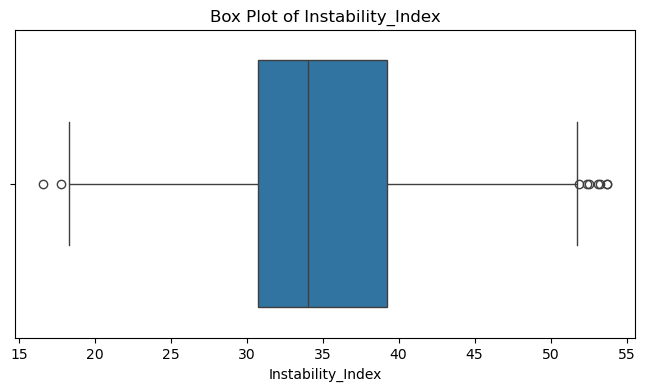

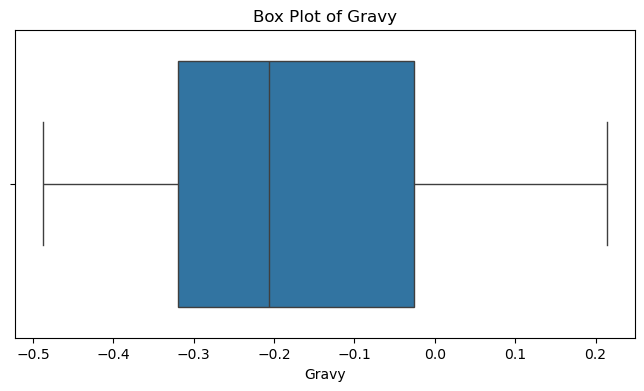

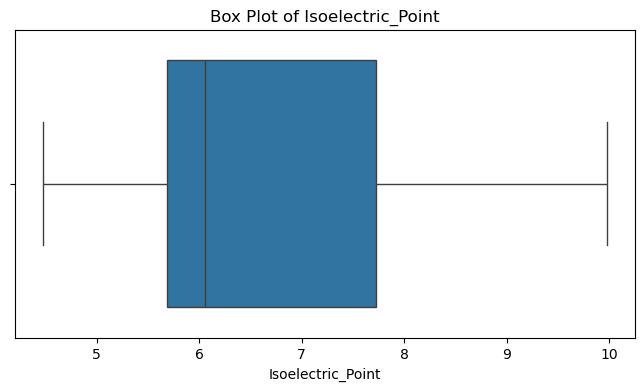

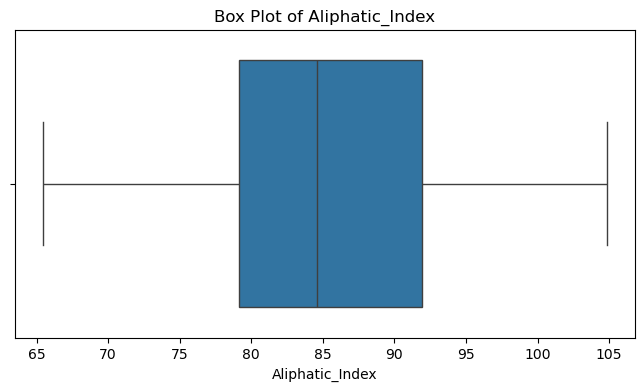

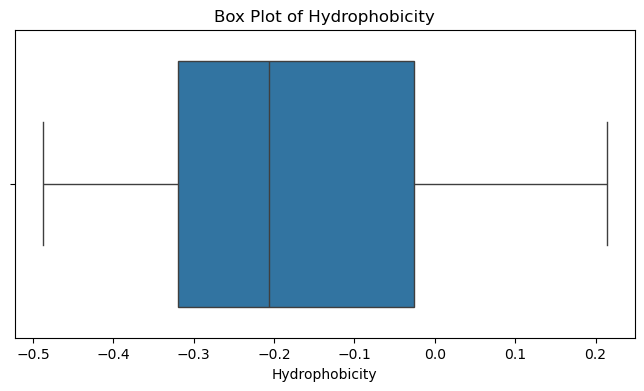

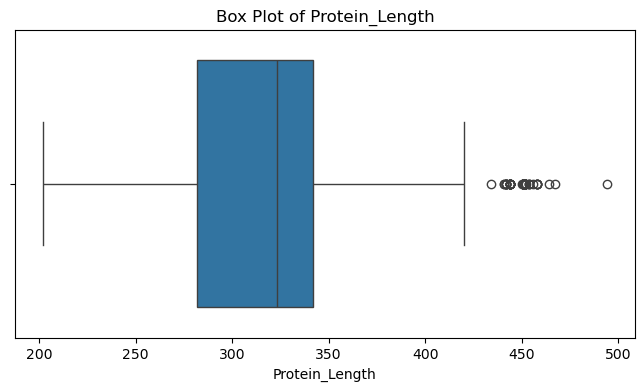

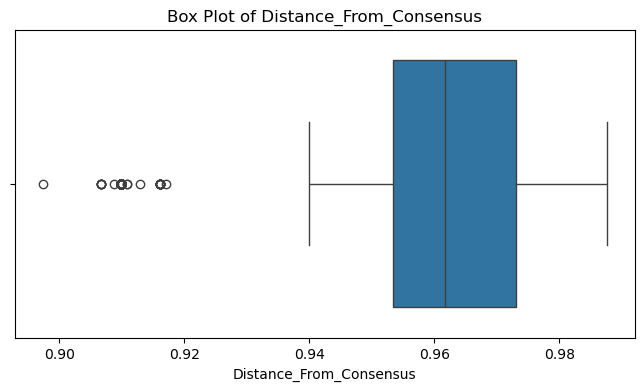

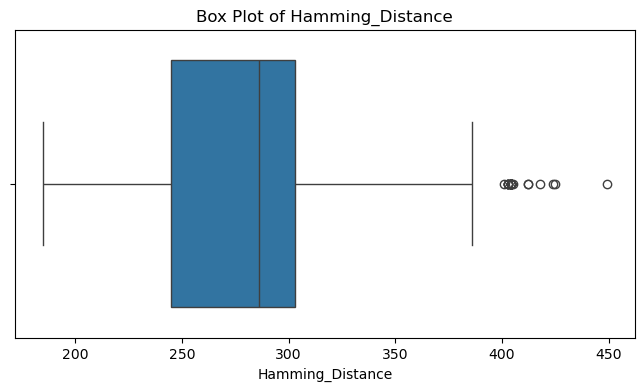

In [30]:
# Create box plots for each feature
for feature in key_features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=combined_lysin_b_df[feature])
    plt.title(f'Box Plot of {feature}')
    plt.show()

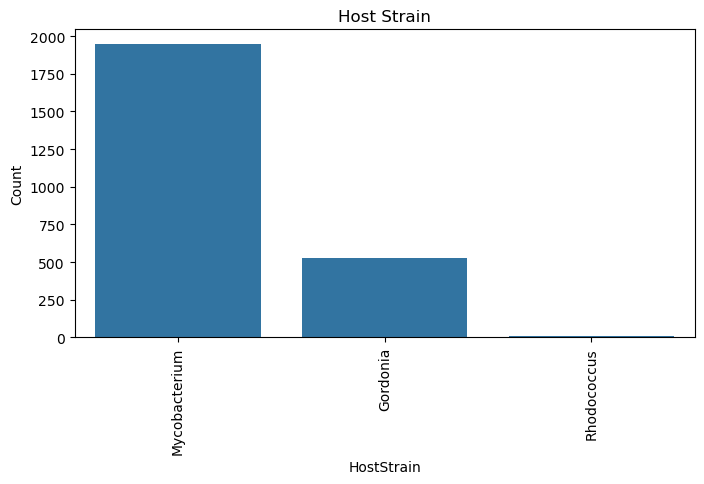

In [31]:
# Plot the distribution of HostStrain
plt.figure(figsize=(8, 4))
sns.countplot(data=combined_lysin_b_df, x='HostStrain', order=combined_lysin_b_df['HostStrain'].value_counts().index)
plt.title('Host Strain')
plt.xticks(rotation=90)
plt.xlabel('HostStrain')
plt.ylabel('Count')
plt.show()

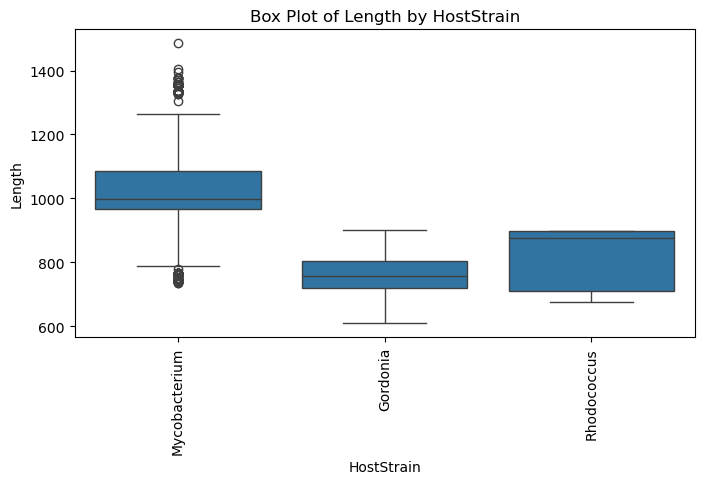

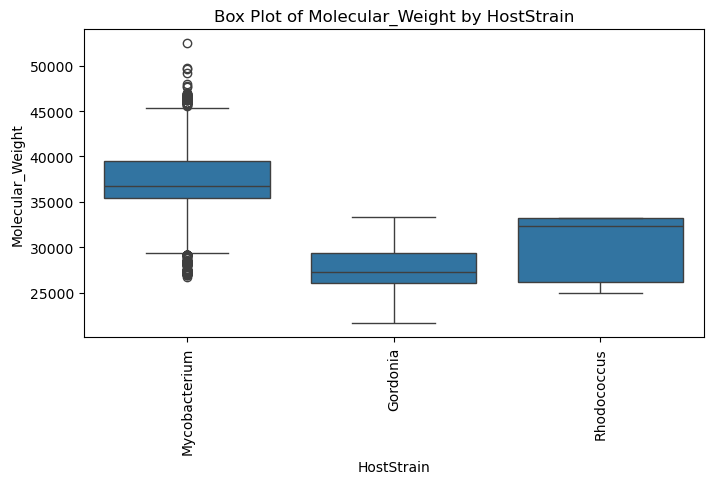

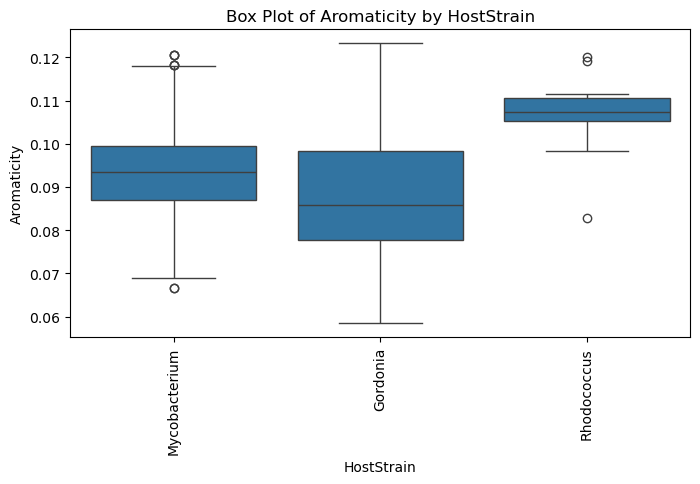

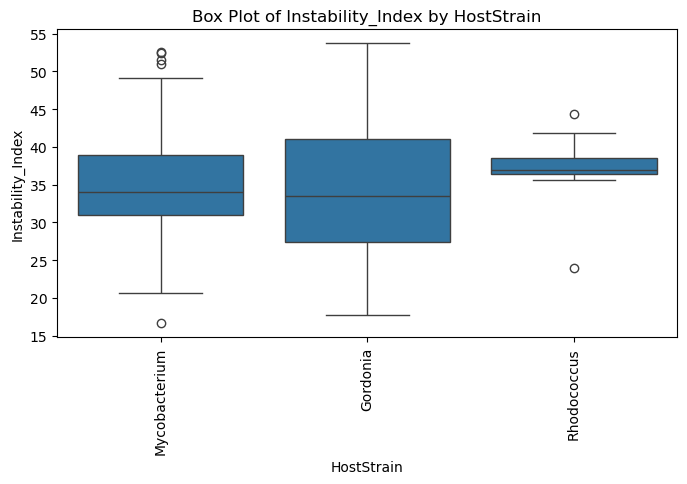

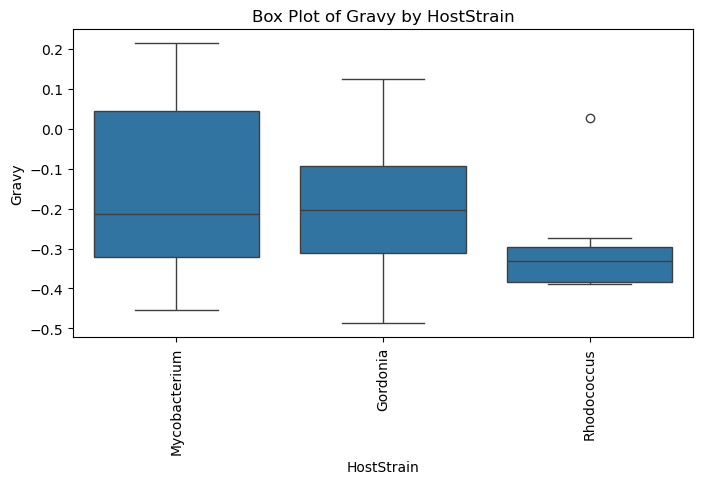

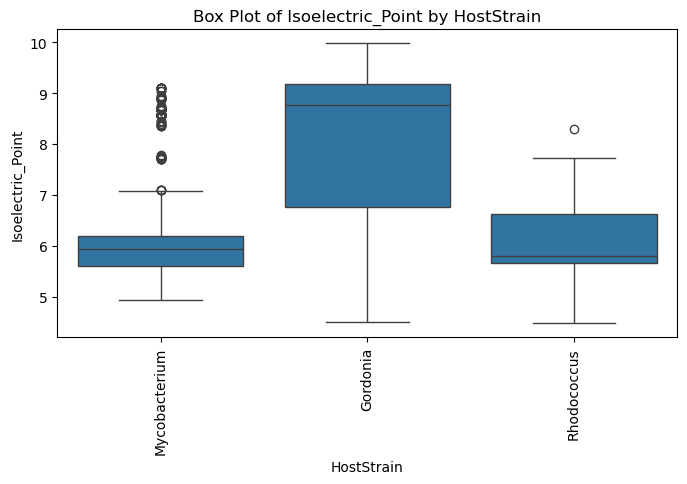

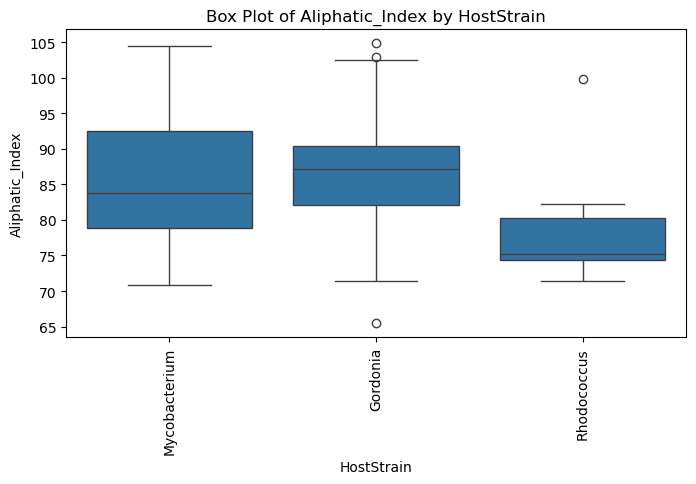

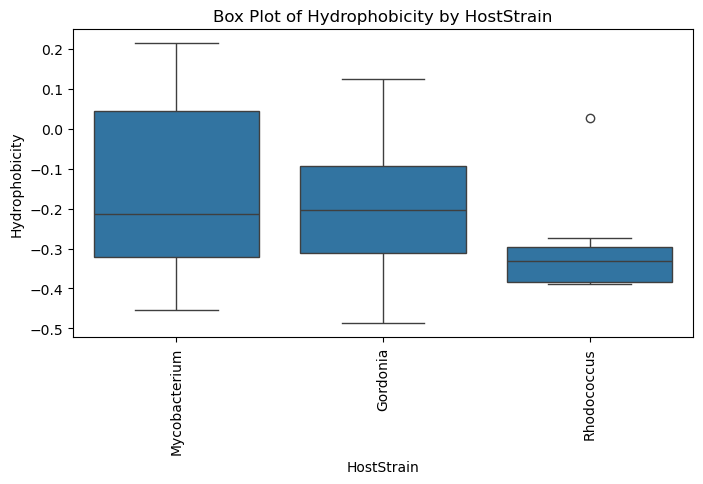

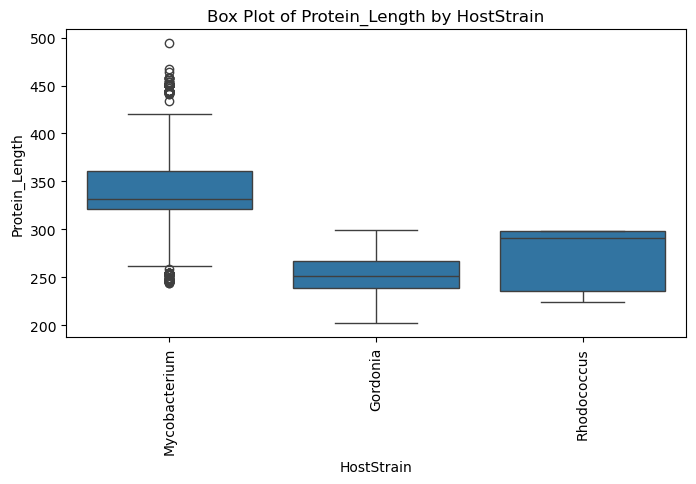

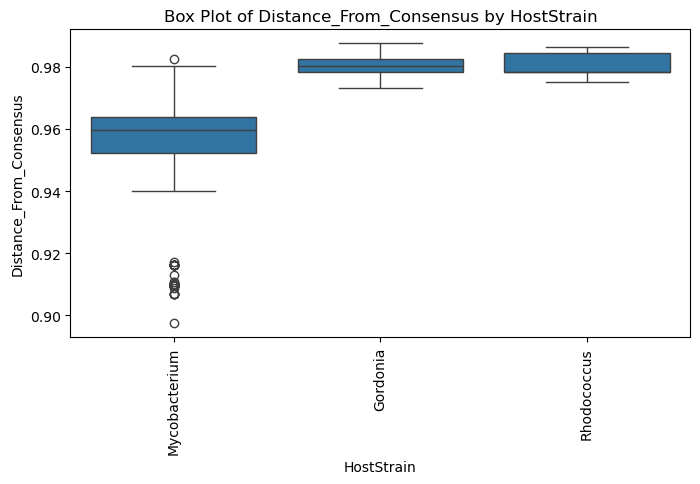

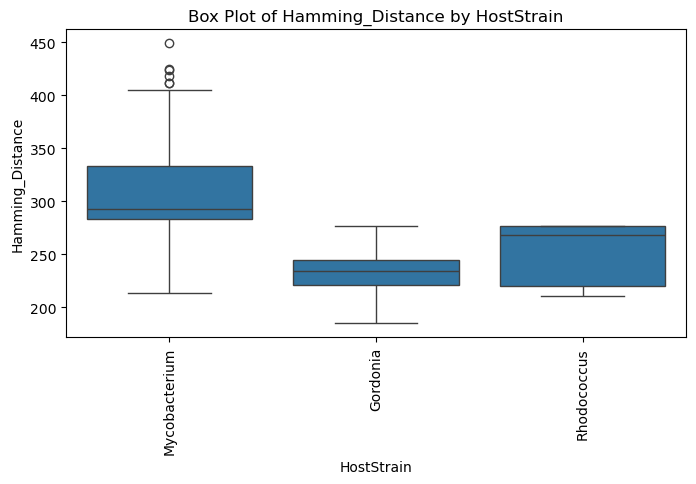

In [32]:
# Create box plots for each feature against HostStrain
for feature in key_features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='HostStrain', y=feature, data=combined_lysin_b_df)
    plt.title(f'Box Plot of {feature} by HostStrain')
    plt.xticks(rotation=90)
    plt.xlabel('HostStrain')
    plt.ylabel(feature)
    plt.show()

In [33]:
# Define the key features sns pair plot
key_features = [
    'Length','Molecular_Weight',
    'Aromaticity', 'Instability_Index', 'Gravy', 'Isoelectric_Point', 
    'Aliphatic_Index', 'Hydrophobicity', 'Protein_Length', 'Distance_From_Consensus', 'Hamming_Distance', 'Cluster_encoded', 'HostStrain_encoded'
]

In [ ]:
# Create pair plots for the key features
sns.pairplot(combined_lysin_b_df, vars=key_features)
plt.suptitle('Pairwise Scatter Plots of Key Features', y=1.02)
plt.show()

In [ ]:
# Function to plot the correlation heatmap and identify highly correlated features for Lysin B
def plot_correlation_heatmap(df):
    correlation_matrix = df[key_features].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f")
    plt.title('Correlation Matrix of Lysin Properties - Lysin B')
    plt.show()
    
    # Identify pairs of highly correlated features (threshold > 0.7 or < -0.7)
    high_corr_pairs = correlation_matrix[(correlation_matrix > 0.7) | (correlation_matrix < -0.7)]
    high_corr_pairs = high_corr_pairs.stack().reset_index()
    high_corr_pairs = high_corr_pairs[high_corr_pairs['level_0'] != high_corr_pairs['level_1']]
    high_corr_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']
    high_corr_pairs = high_corr_pairs[abs(high_corr_pairs['Correlation']) > 0.7]
    
    # Sort feature pairs to avoid duplicates
    high_corr_pairs[['Feature 1', 'Feature 2']] = np.sort(high_corr_pairs[['Feature 1', 'Feature 2']], axis=1)
    
    # Drop duplicate pairs
    high_corr_pairs = high_corr_pairs.drop_duplicates(subset=['Feature 1', 'Feature 2'])
    
    high_corr_pairs['LysinType'] = 'Lysin B'
    return high_corr_pairs

# Plot the heatmap and get highly correlated features for Lysin B
high_corr_pairs = plot_correlation_heatmap(combined_lysin_b_df)

# Display the table of highly correlated features
print("Table of Highly Correlated Features:")
print(high_corr_pairs)

In [ ]:
# Highly correlated pairs from the table
high_corr_pairs = [
    ('Length', 'Molecular_Weight'),
    ('Length', 'Protein_Length'),
    ('Distance_From_Consensus', 'Length'),
    ('Hamming_Distance', 'Length'),
    ('Molecular_Weight', 'Protein_Length'),
    ('Distance_From_Consensus', 'Molecular_Weight'),
    ('Hamming_Distance', 'Molecular_Weight'),
    ('Aliphatic_Index', 'Gravy'),
    ('Gravy', 'Hydrophobicity'),
    ('Aliphatic_Index', 'Hydrophobicity'),
    ('Distance_From_Consensus', 'Protein_Length'),
    ('Hamming_Distance', 'Protein_Length'),
    ('Distance_From_Consensus', 'Hamming_Distance')
]

# Create scatter plots with regression lines
def plot_scatter_with_regression(df, feature1, feature2):
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=feature1, y=feature2, data=df)
    sns.regplot(x=feature1, y=feature2, data=df, scatter=False,)
    plt.title(f'Scatter Plot of {feature1} vs {feature2}')
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.show()

# Calculate Pearson correlation coefficients
def calculate_pearson_correlation(df, feature1, feature2):
    correlation, p_value = pearsonr(df[feature1], df[feature2])
    return correlation, p_value

# Initialize a list to store the results
pearson_results_list = []

# Plot scatter plots with regression lines and calculate Pearson correlations
for feature1, feature2 in high_corr_pairs:
    plot_scatter_with_regression(combined_lysin_b_df, feature1, feature2)
    correlation, p_value = calculate_pearson_correlation(combined_lysin_b_df, feature1, feature2)
    print(f"Pearson correlation coefficient between {feature1} and {feature2}: {correlation}, P-value: {p_value}")
    
    # Store the results in the list
    pearson_results_list.append({
        'Feature 1': feature1,
        'Feature 2': feature2,
        'Pearson Correlation': correlation,
        'P-value': p_value
    })

# Convert the list to a DataFrame
pearson_results = pd.DataFrame(pearson_results_list)

# Display the table of Pearson correlation coefficients and p-values
print("Table of Pearson Correlation Coefficients and P-values:")
print(pearson_results)

Key Observations
Length and Molecular Weight

Correlation: 0.991428
Interpretation: This near-perfect positive correlation indicates that as the length of the protein increases, its molecular weight also increases. This is expected since longer proteins are composed of more amino acids, thus having a higher molecular weight.
Length and Protein Length

Correlation: 1.000000
Interpretation: This perfect positive correlation suggests that the two variables 'Length' and 'Protein Length' are either the same or measured in a way that they are perfectly aligned.
Distance From Consensus and Length

Correlation: -0.860155
Interpretation: This strong negative correlation indicates that sequences further from the consensus tend to be shorter in length.
Hamming Distance and Length

Correlation: 0.979272
Interpretation: This strong positive correlation suggests that longer sequences tend to have a higher Hamming distance, which makes sense as longer sequences have more opportunities for variations.
Molecular Weight and Protein Length

Correlation: 0.991428
Interpretation: Similar to the correlation between Length and Molecular Weight, this indicates that protein length and molecular weight are almost perfectly correlated.
Distance From Consensus and Molecular Weight

Correlation: -0.820767
Interpretation: This negative correlation indicates that proteins that are further from the consensus sequence tend to have lower molecular weights.
Hamming Distance and Molecular Weight

Correlation: 0.983592
Interpretation: This strong positive correlation suggests that proteins with a higher Hamming distance from the consensus tend to have higher molecular weights.
Aliphatic Index and Gravy

Correlation: 0.823117
Interpretation: This indicates a strong positive correlation between the aliphatic index and the gravy (hydrophobicity) score, suggesting that more aliphatic proteins are also more hydrophobic.
Gravy and Hydrophobicity

Correlation: 1.000000
Interpretation: This perfect correlation shows that these two features are measuring the same property of the proteins.
Aliphatic Index and Hydrophobicity

Correlation: 0.823117
Interpretation: Similar to the correlation between Aliphatic Index and Gravy, this indicates that proteins with a higher aliphatic index tend to be more hydrophobic.
Distance From Consensus and Protein Length

Correlation: -0.860155
Interpretation: Same as the correlation between Distance From Consensus and Length, it indicates that sequences further from the consensus tend to be shorter in protein length.
Hamming Distance and Protein Length

Correlation: 0.979272
Interpretation: Same as the correlation between Hamming Distance and Length, it indicates that longer protein sequences tend to have a higher Hamming distance.
Distance From Consensus and Hamming Distance

Correlation: -0.739018
Interpretation: This indicates a strong negative correlation, meaning that sequences closer to the consensus have lower Hamming distances.
Statistical Significance
All the correlations have a p-value of 0.0, indicating that these correlations are statistically significant. This means the observed correlations are highly unlikely to be due to random chance.

Implications
Protein Length and Molecular Weight: Understanding that these features are highly correlated is useful for predicting one based on the other.
Distance from Consensus and Protein Characteristics: Knowing that sequences further from the consensus tend to have lower molecular weights and shorter lengths can help in identifying significant mutations or variations.
Hydrophobicity: The strong correlations between Gravy, Hydrophobicity, and Aliphatic Index suggest these features can be used interchangeably in analyses focusing on protein hydrophobicity.

In [ ]:
# Save the DataFrame to a JSON file
combined_lysin_b_df.to_json('combined_lysin_b_df.json', orient='records', lines=True)